# Basic Dataset Starter

This notebook contains very basic starter code for loading the real vs fake faces dataset from file and working with it. You can borrow from this to:
- start training new models (for the transfer learning and custom architecture subteams)
- analyze and look into the dataset plus implement data augmentation

## Download the data from Kaggle

In [1]:
!rm -rf real_and_fake_face real_and_fake_face_detection processed

In [3]:
from google.colab import drive
from subprocess import Popen, PIPE
# makes files from your drive accessible
drive.mount('/content/drive', force_remount=True)

# TODO - specify path to your API key via google drive
#api_key_filepath = "/content/drive/MyDrive/ColabNotebooks/kaggle.json"
api_key_filepath = "/content/drive/MyDrive/MDST/RvF/kaggle.json"

# Kaggle API Key setup ------------------
cmd = "mkdir /root/.kaggle"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
cmd = f"cp -f {api_key_filepath} /root/.kaggle/"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
cmd = f"chmod 600 /root/.kaggle/kaggle.json"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
# ------------------------------
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip -q real-and-fake-face-detection.zip

Mounted at /content/drive
 mkdir: cannot create directory ‘/root/.kaggle’: File exists

 
 
100% 431M/431M [00:21<00:00, 22.7MB/s]
100% 431M/431M [00:21<00:00, 21.0MB/s]


# Setup PyTorch Data Loading

The code in the next cell can be copied into your notebook to load the downloaded data correctly. It does two things:
- processes the dataset into a train and test set
- creates data loaders for the training and testing data

Don't worry about the details, but if you're on the dataset team, you'll want to read carefully through this part to understand how the code works (since you'll be editing this to make your own version of the dataset!)

In [64]:
from imageio.v3 import imread
import pandas as pd
from pathlib import Path
from random import random
from shutil import copy
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional
from torchvision.transforms import functional
from torchvision import transforms

class RealAndFakeFaceProcessor:
    def __init__(self, directory, train_test_split = 0.7) -> None:
        self.train_test_split = train_test_split

        self.train_index = 0
        self.test_index = 0

        self.src_directory = Path(directory)
        self.directory = self.src_directory.parent / "processed"

        self.tgt_train = self.directory / "train"
        self.tgt_train.mkdir(parents=True, exist_ok=True)

        self.tgt_test = self.directory / "test"
        self.tgt_test.mkdir(parents=True, exist_ok=True)

        self.index_by_type = {"index":[], "partition": [], "type": [], "label": []}
        self.__process("training_fake","easy")
        self.__process("training_fake","mid")
        self.__process("training_fake","hard")
        self.__process("training_real","real")

        df = pd.DataFrame(self.index_by_type)
        df.to_csv(self.directory / "images.csv", index=False)


    def __add_image_to_record(self, index: int, partition: str, type: str, label: int):
        """Real - label is 1, Fake - label is 0"""
        self.index_by_type["index"].append(index)
        self.index_by_type["partition"].append(partition)
        self.index_by_type["type"].append(type)
        self.index_by_type["label"].append(label)


    def __process(self, subdir: str, type: str) -> None:
        src = self.src_directory / subdir
        label = 1 if type == "real" else 0

        for image in src.iterdir():
            if image.name.startswith(type):
                random_number = random()
                if random() > self.train_test_split:
                    copy(image.absolute(), self.tgt_test / f"{self.test_index}.png")
                    self.__add_image_to_record(self.test_index, "test", type, label)
                    self.test_index += 1
                else:
                    copy(image.absolute(), self.tgt_train / f"{self.train_index}.png")
                    self.__add_image_to_record(self.train_index, "train", type, label)
                    self.train_index += 1

class RealAndFakeFaceDataset(Dataset):
    def __init__(
        self,
        directory: str,
        partition: str ="train"
    ) -> 'RealAndFakeFaceDataset':
        self.partition = partition
        if partition not in ("train", "test"):
            raise ValueError(f"Invalid partition specified - {partition}")
        self.directory = Path(directory)
        self.img_directory = self.directory / partition
        metadata = pd.read_csv(self.directory / "images.csv")
        self.metadata = metadata[metadata["partition"] == self.partition]

    def __len__(self) -> int:
        return len(self.metadata)

    def __getitem__(self, index: int) -> tuple[torch.tensor, int]:
        filename = self.img_directory / f"{index}.png"
        label = self.metadata.iloc[index]["label"]

        image = torch.from_numpy(imread(filename))
        image = image.to(torch.float32)
        image = image.permute((2,0,1))
        image = functional.resize(image, (224, 224), antialias=True)
        image /= 255.0
        image_mean = [.485, .456, .406]
        image_std = [.229, .224, .225]

        preprocess = transforms.Compose([
            transforms.Normalize(mean = image_mean, std = image_std),
            transforms.RandomCrop((200,200)),
            transforms.RandomRotation((-15,15), expand=False),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        ])
        image = preprocess(image)


        return image, label

    def get_type(self, index) -> str:
        return self.metadata.iloc[index]["type"]

processor = RealAndFakeFaceProcessor("real_and_fake_face") # Call this to process the dataset into a train and test set
train = RealAndFakeFaceDataset("processed", "train")
test = RealAndFakeFaceDataset("processed", "test")

train_loader = DataLoader(train, batch_size = 32, shuffle=True)
test_loader = DataLoader(test, batch_size = 32)

# Example Usage - Looking at Images

Image 0 in the training set has type easy and is fake


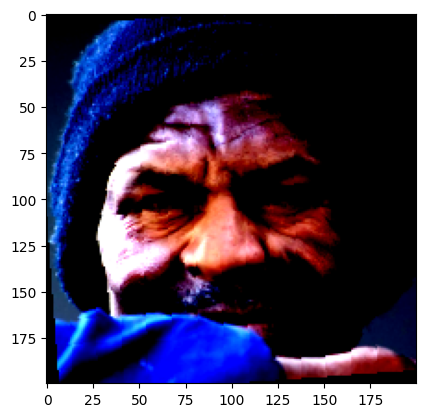

In [53]:
from matplotlib import pyplot as plt

# getting the first image in the training set
index = 0
image, label = train[index]
print(f"Image {index} in the training set has type {train.get_type(index)} and is {'fake' if label == 0 else 'real'}")
plt.imshow(image.permute((1,2,0)))

Image 0 in the testing set has type easy and is fake


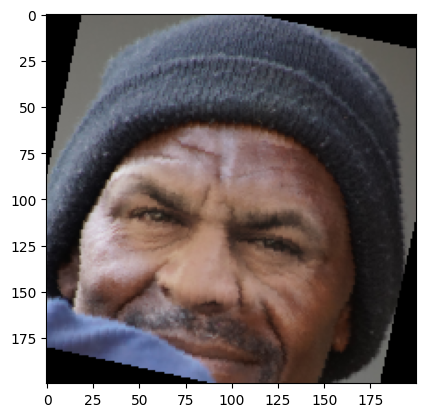

In [51]:
# getting the first image in the testing set
index = 0
image, label = test[index]
print(f"Image {index} in the testing set has type {test.get_type(index)} and is {'fake' if label == 0 else 'real'}")
plt.imshow(image.permute((1,2,0)))

# Example Usage - training a basic PyTorch model

In [ ]:
from tqdm import tqdm
import torch

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 3, padding = "same")
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = "same")
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = "same")
        self.conv4 = torch.nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = "same")
        self.conv5 = torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = "same")
        self.conv6 = torch.nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = "same")
        self.dense1 = torch.nn.Linear(2304, 768)
        self.dense2 = torch.nn.Linear(768, 384)
        self.dense3 = torch.nn.Linear(384, 2)
        self.norm_layer1 = nn.BatchNorm2d(32)
        self.norm_layer2 = nn.BatchNorm2d(64)
        self.norm_layer3 = nn.BatchNorm2d(128)
        self.norm_layer4 = nn.BatchNorm2d(128)
        self.norm_layer5 = nn.BatchNorm2d(256)
        self.norm_layer6 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.activation = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.init_weight()
    def init_weight(self):
        conv = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]
        dense = [self.dense1, self.dense2]
        for layer in conv:
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            torch.nn.init.zeros_(layer.bias)
        for layer in dense:
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            torch.nn.init.zeros_(layer.bias)
    def forward(self, x):
        x = self.pool(self.activation(self.norm_layer1(self.conv1(x))))
        x = self.pool(self.activation(self.norm_layer2(self.conv2(x))))
        x = self.pool(self.activation(self.norm_layer3(self.conv3(x))))
        x = self.pool(self.activation(self.norm_layer4(self.conv4(x))))
        x = self.pool(self.activation(self.norm_layer5(self.conv5(x))))
        x = self.dropout1(x)
        x = self.pool(self.activation(self.norm_layer6(self.conv6(x))))
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        return self.dense3(x)

In [65]:
from tqdm import tqdm
import torch

class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 3, padding = "same")
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = "same")
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = "same")
        self.conv4 = torch.nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = "same")
        self.conv5 = torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = "same")
        self.conv6 = torch.nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = "same")
        self.norm_layer1 = torch.nn.BatchNorm2d(32)
        self.norm_layer2 = torch.nn.BatchNorm2d(64)
        self.norm_layer3 = torch.nn.BatchNorm2d(128)
        self.norm_layer4 = torch.nn.BatchNorm2d(128)
        self.norm_layer5 = torch.nn.BatchNorm2d(256)
        self.norm_layer6 = torch.nn.BatchNorm2d(256)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.activation = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.dropout2d = torch.nn.Dropout2d(0.6)

        # linear layers
        self.dense1_v2 = torch.nn.Linear(2304, 200)
        self.dense2_v2 = torch.nn.Linear(200, 100)
        self.dense3_v2 = torch.nn.Linear(100, 2)
        self.dropout3_v2 = torch.nn.Dropout(0.5)

        self.init_weight()
    def init_weight(self):
        conv = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]
        dense = [self.dense1_v2, self.dense2_v2, self.dense3_v2]#, self.dense4_v2, self.dense5_v2]
        for layer in conv:
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            torch.nn.init.zeros_(layer.bias)
        for layer in dense:
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            torch.nn.init.zeros_(layer.bias)
    def forward(self, x):
        x = self.pool(self.activation(self.norm_layer1(self.conv1(x))))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.norm_layer2(self.conv2(x))))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.norm_layer3(self.conv3(x))))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.norm_layer4(self.conv4(x))))
        x = self.dropout2d(x)

        x = self.pool(self.activation(self.norm_layer5(self.conv5(x))))
        x = self.dropout1(x)
        x = self.pool(self.activation(self.norm_layer6(self.conv6(x))))
        x = self.dropout2(x)
        x = self.flatten(x)

        #self.dropout3_v2 = torch.nn.Dropout(0.5)
        x = self.activation(self.dense1_v2(x))
        x = self.dropout3_v2(x)
        x = self.activation(self.dense2_v2(x))
        x = self.dropout3_v2(x)
        return self.dense3_v2(x)

In [6]:
from typing import Callable
from torch import nn
from torch.utils.data import DataLoader

def evaluate(model: nn.Module, criterion: Callable, loader: DataLoader, device='cuda') -> tuple[float]:
    with torch.no_grad():
        correct, total = 0,0
        loss = 0.0
        for i, (X, y) in enumerate(loader):
            outputs = model(X.to(device)).to('cpu')
            loss += criterion(outputs, y).item()
            _, predicted = torch.max(outputs.data, 1) # get predicted class
            total += len(y)
            correct += (predicted == y).sum().item()
    return correct / total, loss / total

In [66]:
device ='cuda' if torch.cuda.is_available() else 'cpu' # automatically use gpu if available
model = Net2().to(device)

model.load_state_dict(torch.load("/content/epoch=8-checkpoint.pth"), strict = False)

for name, parameter in model.named_parameters():
    if (name[0:4] == "conv"):
      parameter.requires_grad = False

_IncompatibleKeys(missing_keys=['dense1_v2.weight', 'dense1_v2.bias', 'dense2_v2.weight', 'dense2_v2.bias', 'dense3_v2.weight', 'dense3_v2.bias'], unexpected_keys=['dense1.weight', 'dense1.bias', 'dense2.weight', 'dense2.bias', 'dense3.weight', 'dense3.bias'])

In [68]:
from tqdm import tqdm

# run for 20 epoch, remove aumentation step, run for 10 more epochs

device ='cuda' if torch.cuda.is_available() else 'cpu' # automatically use gpu if available
epochs = 3  # Change Number of epochs
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
#model = Net().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay= 0.001)

for epoch in range(epochs):
    for i, (X, y) in enumerate(tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    train_accuracy, train_loss = evaluate(model, criterion, train_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy, test_loss = evaluate(model, criterion, test_loader, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(
        f"Epoch {epoch + 1}: Loss - (Train {train_loss:.5f}/Test {test_loss:.2f}, "
        f"Accuracy - (Train {train_accuracy:.5f}/Test {test_accuracy:.2f})"
    )

100%|██████████| 44/44 [00:35<00:00,  1.23it/s]


Epoch 1: Loss - (Train 0.02208/Test 0.02, Accuracy - (Train 0.52996/Test 0.52)


100%|██████████| 44/44 [00:37<00:00,  1.17it/s]


Epoch 2: Loss - (Train 0.02169/Test 0.02, Accuracy - (Train 0.52996/Test 0.52)


100%|██████████| 44/44 [00:40<00:00,  1.08it/s]


Epoch 3: Loss - (Train 0.02209/Test 0.02, Accuracy - (Train 0.49929/Test 0.51)


In [75]:
#result = model(test[42])

for i, (X, y) in enumerate(test_loader):

  x_single = X[0]
  y_single = y[0]
  outputs = model(X.to(device)).to('cpu')
  loss = criterion(outputs, y).item()
  _, predicted = torch.max(outputs.data, 1) # get predicted class
  break

print(x_single)
print("label:","real" if y_single == 1 else "fake")
print("predicted:","real" if predicted[0] == 1 else "fake")

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
label: fake
predicted: real


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://9800-34-124-157-154.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


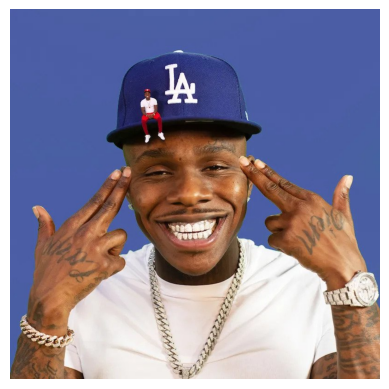

ERROR:__main__:Exception on /upload [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-90-607485fe6092>", line 36, in upload_file
    output = model(img)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    r

In [ ]:
!pip install flask flask-ngrok
!pip install Pillow
from PIL import Image


import numpy as np
from flask import Flask, request, send_file
from flask_ngrok import run_with_ngrok
import os
def display_image(filename):
    # Open and display the image in the notebook
    img = Image.open(filename)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
app = Flask(__name__)
run_with_ngrok(app)   # Start
#ngrok
@app.route("/upload", methods=['POST'])
def upload_file():
    if request.method == 'POST':
        # file or nah
        if 'file' not in request.files:
            return "No file part in the request"
        file = request.files['file']        # empty
        if file.filename == '':
            return "No selected file"
        if file:
            # Save the file temporarily
            filename = "received_file.jpg"
            file.save(filename)
            # Display the image in the notebook
            display_image(filename)

            img = Image.open(filename)
            output = model(img)
            pred = torch.argmax(output, dim=1)
            return "real" if pred==torch.tensor(1) else "fake"
            # Process and return the file as before
            #return send_file(filename, as_attachment=True)

if __name__ == '__main__':
  app.run()


In [ ]:
from imageio.v3 import imread
import pandas as pd
from pathlib import Path
from random import random
from shutil import copy
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional
from torchvision.transforms import functional
from torchvision import transforms

class RealAndFakeFaceProcessor:
    def __init__(self, directory, train_test_split = 0.7) -> None:
        self.train_test_split = train_test_split

        self.train_index = 0
        self.test_index = 0

        self.src_directory = Path(directory)
        self.directory = self.src_directory.parent / "processed"

        self.tgt_train = self.directory / "train"
        self.tgt_train.mkdir(parents=True, exist_ok=True)

        self.tgt_test = self.directory / "test"
        self.tgt_test.mkdir(parents=True, exist_ok=True)

        self.index_by_type = {"index":[], "partition": [], "type": [], "label": []}
        self.__process("training_fake","easy")
        self.__process("training_fake","mid")
        self.__process("training_fake","hard")
        self.__process("training_real","real")

        df = pd.DataFrame(self.index_by_type)
        df.to_csv(self.directory / "images.csv", index=False)


    def __add_image_to_record(self, index: int, partition: str, type: str, label: int):
        """Real - label is 1, Fake - label is 0"""
        self.index_by_type["index"].append(index)
        self.index_by_type["partition"].append(partition)
        self.index_by_type["type"].append(type)
        self.index_by_type["label"].append(label)


    def __process(self, subdir: str, type: str) -> None:
        src = self.src_directory / subdir
        label = 1 if type == "real" else 0

        for image in src.iterdir():
            if image.name.startswith(type):
                random_number = random()
                if random() > self.train_test_split:
                    copy(image.absolute(), self.tgt_test / f"{self.test_index}.png")
                    self.__add_image_to_record(self.test_index, "test", type, label)
                    self.test_index += 1
                else:
                    copy(image.absolute(), self.tgt_train / f"{self.train_index}.png")
                    self.__add_image_to_record(self.train_index, "train", type, label)
                    self.train_index += 1

class RealAndFakeFaceDataset(Dataset):
    def __init__(
        self,
        directory: str,
        partition: str ="train"
    ) -> 'RealAndFakeFaceDataset':
        self.partition = partition
        if partition not in ("train", "test"):
            raise ValueError(f"Invalid partition specified - {partition}")
        self.directory = Path(directory)
        self.img_directory = self.directory / partition
        metadata = pd.read_csv(self.directory / "images.csv")
        self.metadata = metadata[metadata["partition"] == self.partition]

    def __len__(self) -> int:
        return len(self.metadata)

    def __getitem__(self, index: int) -> tuple[torch.tensor, int]:
        filename = self.img_directory / f"{index}.png"
        label = self.metadata.iloc[index]["label"]

        image = torch.from_numpy(imread(filename))
        image = image.to(torch.float32)
        image = image.permute((2,0,1))
        image = functional.resize(image, (224, 224), antialias=True)
        image /= 255.0
        image_mean = [.485, .456, .406]
        image_std = [.229, .224, .225]

        preprocess = transforms.Compose([
            transforms.Normalize(mean = image_mean, std = image_std),
            transforms.RandomCrop((200,200)),
            transforms.RandomRotation((-15,15), expand=False),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        ])
        image = preprocess(image)


        return image, label

    def get_type(self, index) -> str:
        return self.metadata.iloc[index]["type"]

processor = RealAndFakeFaceProcessor("real_and_fake_face") # Call this to process the dataset into a train and test set
train = RealAndFakeFaceDataset("processed", "train")
test = RealAndFakeFaceDataset("processed", "test")

train_loader = DataLoader(train, batch_size = 32, shuffle=True)
test_loader = DataLoader(test, batch_size = 32)
#
#